### **WIP, still trying to determine why the CDF estimates don't match ESPN's website. prior to that, I can't confirm I'm getting the same distributions that are made available by ESPN

# analyze watson projection data
ref http://ben-tanen.com/projects/2020/01/08/ibm-watson-ff.html (ppr)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
w = pd.read_csv(r'data/ibm-watson-ff-projections-2019.csv')
w.head()

,player,week,actual_score,proj_score,boom_pct,boom_pts,bust_pct,bust_pts,mid_pct
0,49ers D/ST,Week 01 vs Bucs,28.0,6.3,0.24,12.6,0.10,4.3,0.66
1,49ers D/ST,Week 02 vs Bengals,7.0,6.1,0.23,15.3,0.08,4.1,0.69
2,49ers D/ST,Week 03 vs Steelers,8.0,7.4,0.23,13.0,0.19,4.3,0.58
3,49ers D/ST,Week 05 vs Browns,19.0,6.0,0.14,14.7,0.21,3.7,0.65
4,49ers D/ST,Week 06 vs Rams,12.0,6.0,0.23,14.6,0.14,4.1,0.63


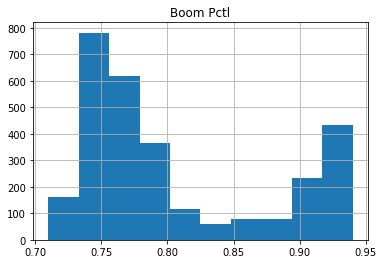

In [2]:
(1 - w.boom_pct).hist()
plt.title('Boom Pctl')
plt.show()

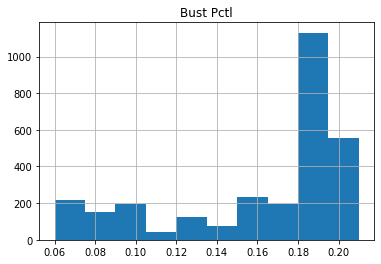

In [3]:
w.bust_pct.hist()
plt.title('Bust Pctl')
plt.show()

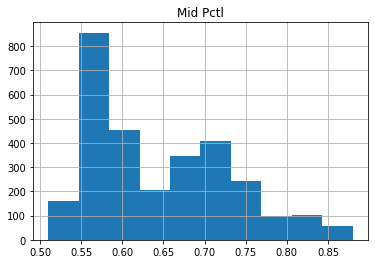

In [4]:
w.mid_pct.hist()
plt.title('Mid Pctl')
plt.show()

In [5]:
import requests

here is a link to access josh jacob's watson distribution data. let's test it out to make sure the distribution looks correct!
https://watsonfantasyfootball.espn.com/espnpartner/dallas/players/players_4047365_ESPNFantasyFootball_2020.json
https://watsonfantasyfootball.espn.com/espnpartner/dallas/projections/projections_4047365_ESPNFantasyFootball_2020.json

In [6]:

pid = 16799
resp = json.loads(requests.get('https://watsonfantasyfootball.espn.com/espnpartner/dallas/projections/projections_{}_ESPNFantasyFootball_2020.json'.format(pid)).text)
len(resp)

83

In [7]:
pid = 16799
hold = json.loads(requests.get('https://watsonfantasyfootball.espn.com/espnpartner/dallas/classifiers/classifiers_{}_ESPNFantasyFootball_2020.json'.format(pid)).text)

In [8]:
pd.DataFrame(hold).loc[:, ['DATA_TIMESTAMP', 'MODEL_TYPE', 'NORMALIZED_RESULT']].set_index('DATA_TIMESTAMP').pivot(columns=['MODEL_TYPE'])

NORMALIZED_RESULT                  \
MODEL_TYPE                 breakout_classifier bust_classifier   
DATA_TIMESTAMP                                                   
2020-09-27 00:00:00.000000            0.160168        0.185084   
2020-09-28 00:00:00.000000            0.148601        0.084539   
2020-09-29 00:00:00.000000            0.212582        0.084702   
2020-09-30 00:00:00.000000            0.261395        0.175934   
2020-10-01 00:00:00.000000            0.194582        0.077249   
...                                        ...             ...   
2020-12-21 00:00:00.000000            0.269480        0.269643   
2020-12-22 00:00:00.000000            0.265894        0.250486   
2020-12-23 00:00:00.000000            0.269480        0.269643   
2020-12-24 00:00:00.000000            0.260396        0.265081   
2020-12-25 00:00:00.000000            0.257819        0.269643   

                                                        \
MODEL_TYPE                 play_with_injury_classifier   
DATA_TIMESTAMP                                           
2020-09-27 00:00:00.000000                    0.693933   
2020-09-28 00:00:00.000000                    0.792011   
2020-09-29 00:00:00.000000                    0.762432   
2020-09-30 00:00:00.000000                    0.792473   
2020-10-01 00:00:00.000000                    0.669825   
...                                                ...   
2020-12-21 00:00:00.000000                    0.759052   
2020-12-22 00:00:00.000000                    0.747574   
2020-12-23 00:00:00.000000                    0.694800   
2020-12-24 00:00:00.000000                    0.764306   
2020-12-25 00:00:00.000000                    0.697953   

                                                           
MODEL_TYPE                 play_without_injury_classifier  
DATA_TIMESTAMP                                             
2020-09-27 00:00:00.000000                       0.843172  
2020-09-28 00:00:00.000000                       0.831333  
2020-09-29 00:00:00.000000                       0.973740  
2020-09-30 00:00:00.000000                       0.832345  
2020-10-01 00:00:00.000000                       0.831333  
...                                                   ...  
2020-12-21 00:00:00.000000                       0.831748  
2020-12-22 00:00:00.000000                       0.831333  
2020-12-23 00:00:00.000000                       0.900241  
2020-12-24 00:00:00.000000                       0.831333  
2020-12-25 00:00:00.000000                       0.831333  

[83 rows x 4 columns]

In [9]:
rec = resp[-1]
#rec = x[-1]

In [10]:
import datetime

def parse_date(data_timestamp):
    return datetime.datetime.strptime(data_timestamp[:10], '%Y-%m-%d').date()

parse_date(rec['DATA_TIMESTAMP'])

datetime.date(2020, 12, 25)

In [11]:
def get_week_dates(week_dt):
    return [week_dt + datetime.timedelta(days=-d) for d in range(4,-3,-1)]

def get_all_week_dates(last_sunday, first_sunday=datetime.date(2020,9,13)):
    dt_sun = first_sunday
    dts = {}
    i = 1
    while dt_sun <= last_sunday:
        dts[i] = get_week_dates(dt_sun)
        dt_sun = dt_sun + datetime.timedelta(days=7)
        i += 1
    return dts

last_sunday = [datetime.date.today() + datetime.timedelta(days=d) for d in range(7) if (datetime.date.today() + datetime.timedelta(days=d)).isoweekday() == 7][-1]
all_wk_dts = get_all_week_dates(last_sunday)
all_wk_dts[1], all_wk_dts[max(all_wk_dts.keys())]

([datetime.date(2020, 9, 9),
  datetime.date(2020, 9, 10),
  datetime.date(2020, 9, 11),
  datetime.date(2020, 9, 12),
  datetime.date(2020, 9, 13),
  datetime.date(2020, 9, 14),
  datetime.date(2020, 9, 15)],
 [datetime.date(2020, 12, 23),
  datetime.date(2020, 12, 24),
  datetime.date(2020, 12, 25),
  datetime.date(2020, 12, 26),
  datetime.date(2020, 12, 27),
  datetime.date(2020, 12, 28),
  datetime.date(2020, 12, 29)])

In [12]:
def find_wk_num(dt_str, all_wk_dts):
    for k, v in all_wk_dts.items():
        if parse_date(dt_str) in v:
            return k
        
find_wk_num(rec['DATA_TIMESTAMP'], all_wk_dts)

16

In [13]:
len(json.loads(rec['SCORE_DISTRIBUTION']))

1000

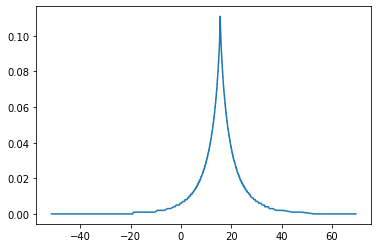

In [14]:
import numpy as np

dist = np.array(json.loads(rec['SCORE_DISTRIBUTION']))
dist[:, 0]
plt.plot(dist[:, 0], dist[:, 1])
plt.show()

In [15]:
def find_nearest_argmin(array, value):
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

end_idx = find_nearest_argmin(dist[:, 0], rec['LOW_SCORE'])
mid_idx3 = find_nearest_argmin(dist[:, 0], rec['OUTSIDE_PROJECTION'])
mid_idx2 = find_nearest_argmin(dist[:, 0], rec['SCORE_PROJECTION'])
mid_idx = find_nearest_argmin(dist[:, 0], rec['SIMULATION_PROJECTION'])
start_idx = find_nearest_argmin(dist[:, 0], rec['HIGH_SCORE'])
dist[:end_idx, 1].sum() / dist[:, 1].sum(), dist[:mid_idx, 1].sum() / dist[:, 1].sum(), dist[start_idx:, 1].sum() / dist[:, 1].sum()

(0.029255777854432556, 0.5110167299068644, 0.03796567781993791)

In [16]:
dist[:mid_idx2, 1].sum() / dist[:, 1].sum(), dist[:mid_idx3, 1].sum() / dist[:, 1].sum()

(0.8233658157985513, 0.6419023801310796)

In [17]:
rec['LOW_SCORE'], rec['SIMULATION_PROJECTION'], rec['HIGH_SCORE']

(8.551, 15.6, 22.649)

ideas for what to do with the distributions:
- to confirm efficacy of the distributions: compute the percentile of each of the estimates according to the distributions and see if it follows a uniform distribution
  - compute into buckets of n=2,5,10, and 100 and plot as a histogram
  - do a permutation test against samples from a uniform ~ (0, 100) to see if the percentiles come from a uniform distribuion in a way that is statistically significant
- to test efficacy of of boom/bust
  - copy model calibration analysis: http://ben-tanen.com/projects/2020/01/08/ibm-watson-ff.html

Calibration analysis